<a href="https://colab.research.google.com/github/amnyqb/solargen/blob/main/Solar_PV_Generation_Forecast_with_Tuned_Random_Forest_and_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
options(repos = c(CRAN = "https://cran.rstudio.com/"))
knitr::opts_chunk$set(echo = TRUE)


# Introduction

This project aims to develop machine learning models for predicting solar power generation using weather data from two solar plants. The dataset consists of temperature, irradiation, and power generation values collected over time from sensors at the solar plants.

The primary objective is to accurately predict the Direct Current (DC) power generated by these plants. We will use different machine learning models, including Random Forest and XGBoost, to train and test on one plant's data and assess the model's performance on the other plant.

### Data Source and Summary

The dataset used in this analysis is available at [Kaggle Solar Data](https://github.com/amnyqb/solar_ml/blob/main/kaggle_solardata.zip). It contains four files:
- Plant 1 Generation Data
- Plant 1 Weather Data
- Plant 2 Generation Data
- Plant 2 Weather Data

Each file includes detailed information on DC power output, temperature (ambient and module), and solar irradiation, collected over several months. In this analysis, we will focus on using the Plant 2 data for training and prediction. Below is a brief summary of the data:

- **Generation Data**: Includes features such as DC Power, AC Power, and Yield (total and daily).
- **Weather Data**: Contains features such as ambient temperature, module temperature, and solar irradiation.

---

# Approach

We will follow a structured approach to build the predictive models:

1. **Data Cleaning and Feature Engineering**: Prepare the data by converting date columns to appropriate formats and creating useful features such as `hour`, `day_of_week`, and `is_weekend`.
2. **Exploratory Data Analysis (EDA)**: Visualize the data to gain insights into the relationships between variables such as temperature, irradiation, and DC power generation.
3. **Model Training**: Implement various machine learning models, including Random Forest and XGBoost, and optimize their parameters.
4. **Model Evaluation**: Compare the models using Root Mean Square Error (RMSE) and other performance metrics.
5. **Conclusion**: Present the final results and discuss potential areas for improvement and future work.

---

## Required Packages

In this analysis, several R packages are required to perform data manipulation, machine learning modeling, and visualization. The following packages will be used:

- `prophet`: For time series forecasting.
- `tensorflow`: To build neural network models like LSTM.
- `randomForest`: For implementing Random Forest models.
- `caret`: For machine learning model training and tuning.
- `lubridate`: To handle date-time features.
- `dplyr`: For data manipulation.
- `ggplot2`: For data visualization.
- `corrplot` and `ggcorrplot`: To create correlation plots.
- `rpart`: For decision tree models.

In [28]:
# Function to install missing packages
install_if_missing <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package, dependencies = TRUE)
    library(package, character.only = TRUE)
  }
}

# List of required packages
required_packages <- c("prophet", "tensorflow", "randomForest",
                       "caret", "lubridate", "dplyr", "ggplot2",
                       "corrplot", "ggcorrplot", "rpart","kableExtra")

# Install missing packages
lapply(required_packages, install_if_missing)


Loading required package: prophet

Loading required package: Rcpp

Loading required package: rlang

Loading required package: tensorflow


Attaching package: ‘tensorflow’


The following object is masked from ‘package:caret’:

    train


Loading required package: kableExtra

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘kableExtra’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘AsioHeaders’, ‘websocket’, ‘chromote’, ‘svglite’, ‘magick’, ‘formattable’, ‘sparkline’, ‘webshot2’


Warning message in install.packages(package, dependencies = TRUE):
“installation of package ‘magick’ had non-zero exit status”

Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows




[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
 [1] "kableExtra"   "tensorflow"   "prophet"      "rlang"        "Rcpp"        
 [6] "e1071"        "rpart"        "xgboost"      "ggcorrplot"   "corrplot"    
[11] "dplyr"        "lubridate"    "caret"        "lattice"      "ggplot2"     
[16] "randomForest" "httr"         "stats"        "graphics"     "grDevices"   
[21] "utils"        "datasets"     "methods"      "base"


# Loading the Data

In this step, we will load the dataset, check for missing values, and convert the `DATE_TIME` column to a proper datetime format.


In [32]:
library(tidyverse)
library(lubridate)
library(caret)
library(randomForest)


# Required libraries for downloading and unzipping files
library(tidyverse)

# Set the URL of the zip file and the destination
url <- "https://github.com/amnyqb/solar_ml/blob/main/kaggle_solardata.zip?raw=true"
destfile <- "kaggle_solardata.zip"

# Check if the file already exists, if not, download it
if (!file.exists(destfile)) {
  download.file(url, destfile, mode = "wb")
}

# Unzip the file if it hasn't been unzipped
if (!dir.exists("kaggle_solardata")) {
  unzip(destfile, exdir = "kaggle_solardata")
}

# Load the CSV files into variables
plant1_gen <- read_csv("kaggle_solardata/Plant_1_Generation_Data.csv")
plant2_gen <- read_csv("kaggle_solardata/Plant_2_Generation_Data.csv")
plant1_weather <- read_csv("kaggle_solardata/Plant_1_Weather_Sensor_Data.csv")
plant2_weather <- read_csv("kaggle_solardata/Plant_2_Weather_Sensor_Data.csv")

head(plant1_data)
head(plant1_weather)
head(plant2_data)
head(plant2_weather)

# Check for missing values
cat("Missing values in Plant 2 Generation Data:\n")
print(sapply(plant2_gen, function(x) sum(is.na(x))))

cat("Missing values in Plant 2 Weather Data:\n")
print(sapply(plant2_weather, function(x) sum(is.na(x))))

# Merge generation and weather data
plant2_data <- merge(plant2_gen, plant2_weather, by = "DATE_TIME")

# Preview the merged data
head(plant2_data)


# Data Cleaning and Feature Engineering

# Convert DATE_TIME to a proper datetime format and extract useful features
plant2_data <- plant2_data %>%
  mutate(DATE_TIME = as.POSIXct(DATE_TIME, format = "%Y-%m-%d %H:%M:%S"),
         hour = as.numeric(format(DATE_TIME, "%H")),
         day_of_week = as.numeric(format(DATE_TIME, "%u")),
         week_number = isoweek(DATE_TIME),
         month = as.numeric(format(DATE_TIME, "%m")),
         year = as.numeric(format(DATE_TIME, "%Y")),
         is_weekend = ifelse(day_of_week > 5, 1, 0))

# Summary after feature engineering
summary(plant2_data)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats 1.0.0     ✔ stringr 1.5.1
✔ purrr   1.0.2     ✔ tibble  3.2.1
✔ readr   2.1.5     ✔ tidyr   1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%@%()             masks rlang::%@%()
✖ dplyr::combine()         masks randomForest::combine()
✖ dplyr::filter()          masks stats::filter()
✖ purrr::flatten()         masks rlang::flatten()
✖ purrr::flatten_chr()     masks rlang::flatten_chr()
✖ purrr::flatten_dbl()     masks rlang::flatten_dbl()
✖ purrr::flatten_int()     masks rlang::flatten_int()
✖ purrr::flatten_lgl()     masks rlang::flatten_lgl()
✖ purrr::flatten_raw()     masks rlang::flatten_raw()
✖ kableExtra::group_rows() masks dplyr::group_rows()
✖ purrr::invoke()          masks rlang::invoke()
✖ dplyr::lag()             masks stats::lag()
✖ purrr::lift()            masks caret::lift()
✖ ggplot2::margin()        masks randomForest::margin()
✖ caret

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0,0,0,6259559
2,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0,0,0,6183645
3,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0,0,0,6987759
4,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0,0,0,7602960
5,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0,0,0,7158964
6,15-05-2020 00:00,4135001,VHMLBKoKgIrUVDU,0,0,0,7206408


DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
<dttm>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.18432,22.85751,0
2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.08459,22.76167,0
2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.93575,22.59231,0
2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.84613,22.36085,0
2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.62153,22.16542,0
2020-05-15 01:15:00,4135001,HmiyD2TTLFNqkNe,24.53609,21.96857,0


,DATE_TIME,PLANT_ID.x,SOURCE_KEY.x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID.y,SOURCE_KEY.y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,hour,day_of_week,is_weekend,week_number,month,year
,<dttm>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2020-05-15 06:00:00,4136001,4UPUqMRk7TRMgml,15.40667,14.86000,0.8000000,2429012,4136001,iq8k7ZNt4Mwm3w0,24.74279,24.07723,0.01296198,6,5,0,20,5,2020
2,2020-05-15 06:00:00,4136001,81aHJ1q11NBPMrL,14.77333,14.24667,0.7333333,1215278737,4136001,iq8k7ZNt4Mwm3w0,24.74279,24.07723,0.01296198,6,5,0,20,5,2020
3,2020-05-15 06:00:00,4136001,9kRcWv60rDACzjR,15.38000,14.84000,1.8666667,2247719579,4136001,iq8k7ZNt4Mwm3w0,24.74279,24.07723,0.01296198,6,5,0,20,5,2020
4,2020-05-15 06:00:00,4136001,Et9kgGMDl729KT4,14.97333,14.44000,1.0000000,1704251,4136001,iq8k7ZNt4Mwm3w0,24.74279,24.07723,0.01296198,6,5,0,20,5,2020
5,2020-05-15 06:00:00,4136001,IQ2d7wF4YD8zU1Q,15.16000,14.63333,0.7333333,19941527,4136001,iq8k7ZNt4Mwm3w0,24.74279,24.07723,0.01296198,6,5,0,20,5,2020
6,2020-05-15 06:00:00,4136001,LYwnQax7tkwH5Cb,15.56667,15.02000,1.2666667,1794958635,4136001,iq8k7ZNt4Mwm3w0,24.74279,24.07723,0.01296198,6,5,0,20,5,2020


DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
<dttm>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
2020-05-15 00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.00476,25.06079,0
2020-05-15 00:15:00,4136001,iq8k7ZNt4Mwm3w0,26.88081,24.42187,0
2020-05-15 00:30:00,4136001,iq8k7ZNt4Mwm3w0,26.68206,24.42729,0
2020-05-15 00:45:00,4136001,iq8k7ZNt4Mwm3w0,26.50059,24.42068,0
2020-05-15 01:00:00,4136001,iq8k7ZNt4Mwm3w0,26.59615,25.08821,0
2020-05-15 01:15:00,4136001,iq8k7ZNt4Mwm3w0,26.51274,25.31797,0


Missing values in Plant 2 Generation Data:
  DATE_TIME    PLANT_ID  SOURCE_KEY    DC_POWER    AC_POWER DAILY_YIELD 
          0           0           0           0           0           0 
TOTAL_YIELD 
          0 
Missing values in Plant 2 Weather Data:
          DATE_TIME            PLANT_ID          SOURCE_KEY AMBIENT_TEMPERATURE 
                  0                   0                   0                   0 
 MODULE_TEMPERATURE         IRRADIATION 
                  0                   0 


,DATE_TIME,PLANT_ID.x,SOURCE_KEY.x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID.y,SOURCE_KEY.y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
,<dttm>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,2020-05-15,4136001,4UPUqMRk7TRMgml,0,0,9425.0000,2429011,4136001,iq8k7ZNt4Mwm3w0,27.00476,25.06079,0
2,2020-05-15,4136001,81aHJ1q11NBPMrL,0,0,0.0000,1215278736,4136001,iq8k7ZNt4Mwm3w0,27.00476,25.06079,0
3,2020-05-15,4136001,9kRcWv60rDACzjR,0,0,3075.3333,2247719577,4136001,iq8k7ZNt4Mwm3w0,27.00476,25.06079,0
4,2020-05-15,4136001,Et9kgGMDl729KT4,0,0,269.9333,1704250,4136001,iq8k7ZNt4Mwm3w0,27.00476,25.06079,0
5,2020-05-15,4136001,IQ2d7wF4YD8zU1Q,0,0,3177.0000,19941526,4136001,iq8k7ZNt4Mwm3w0,27.00476,25.06079,0
6,2020-05-15,4136001,LYwnQax7tkwH5Cb,0,0,1872.5000,1794958634,4136001,iq8k7ZNt4Mwm3w0,27.00476,25.06079,0


   DATE_TIME                        PLANT_ID.x      SOURCE_KEY.x      
 Min.   :2020-05-15 00:00:00.00   Min.   :4136001   Length:67698      
 1st Qu.:2020-05-23 21:00:00.00   1st Qu.:4136001   Class :character  
 Median :2020-06-01 23:00:00.00   Median :4136001   Mode  :character  
 Mean   :2020-06-01 10:44:33.65   Mean   :4136001                     
 3rd Qu.:2020-06-09 23:30:00.00   3rd Qu.:4136001                     
 Max.   :2020-06-17 23:45:00.00   Max.   :4136001                     
    DC_POWER         AC_POWER       DAILY_YIELD      TOTAL_YIELD       
 Min.   :   0.0   Min.   :   0.0   Min.   :   0.0   Min.   :0.000e+00  
 1st Qu.:   0.0   1st Qu.:   0.0   1st Qu.: 272.8   1st Qu.:1.996e+07  
 Median :   0.0   Median :   0.0   Median :2911.0   Median :2.826e+08  
 Mean   : 246.7   Mean   : 241.3   Mean   :3294.9   Mean   :6.589e+08  
 3rd Qu.: 446.6   3rd Qu.: 438.2   3rd Qu.:5534.0   3rd Qu.:1.348e+09  
 Max.   :1420.9   Max.   :1385.4   Max.   :9873.0   Max.   :2.248e+09  


# Exploratory Data Analysis (EDA)

The following visualizations provide insights into the relationships between key features such as temperature, irradiation, and DC power generation. These insights will guide our model-building process.

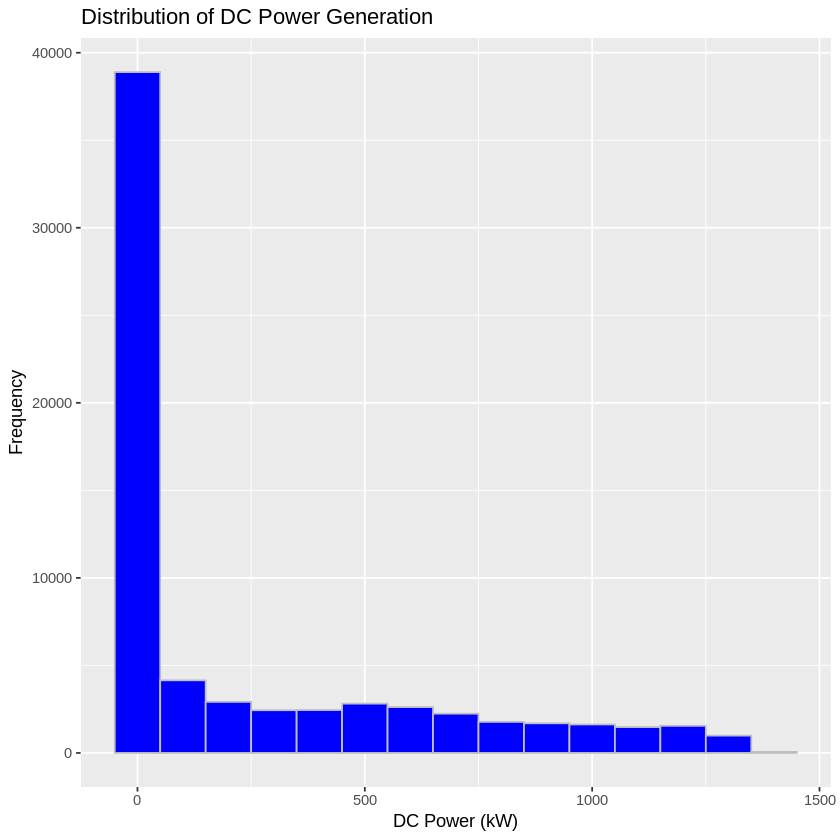

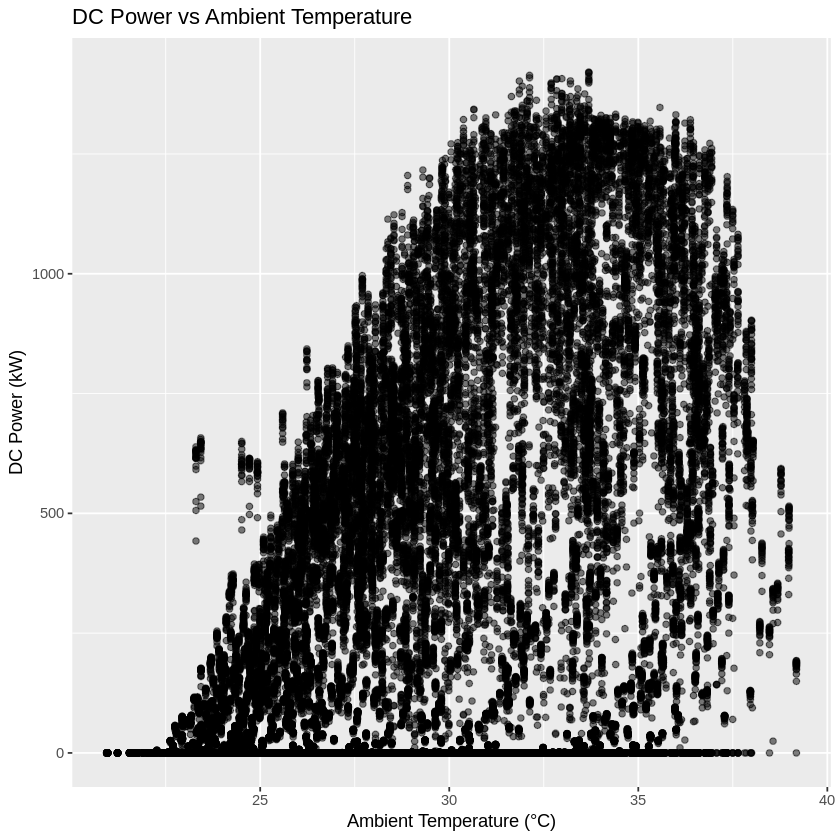

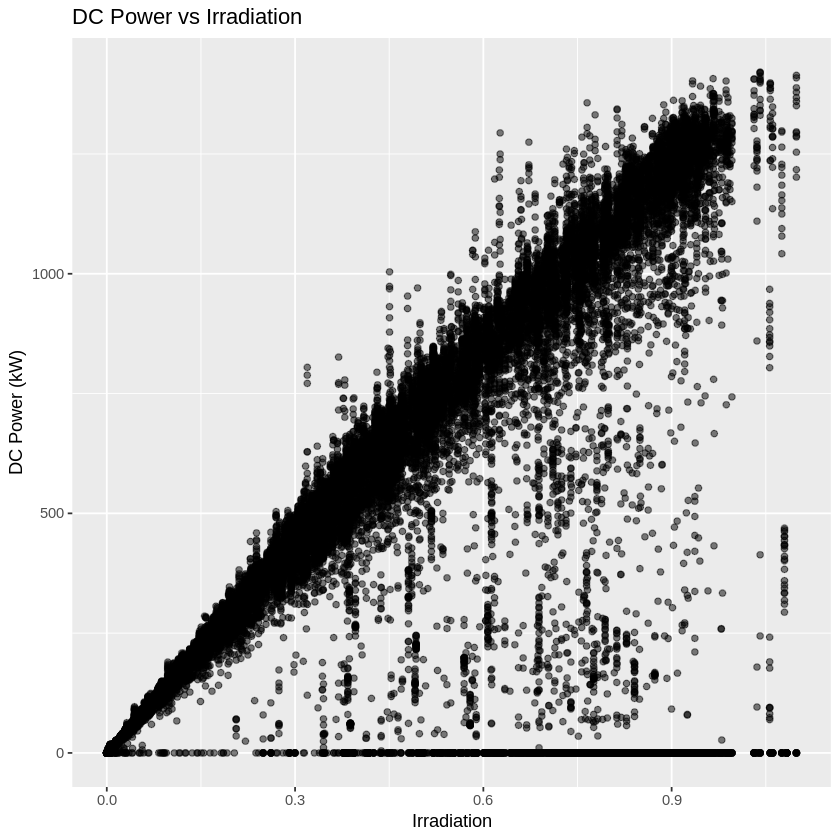

Warning message:
“Continuous x aesthetic
ℹ did you forget `aes(group = ...)`?”


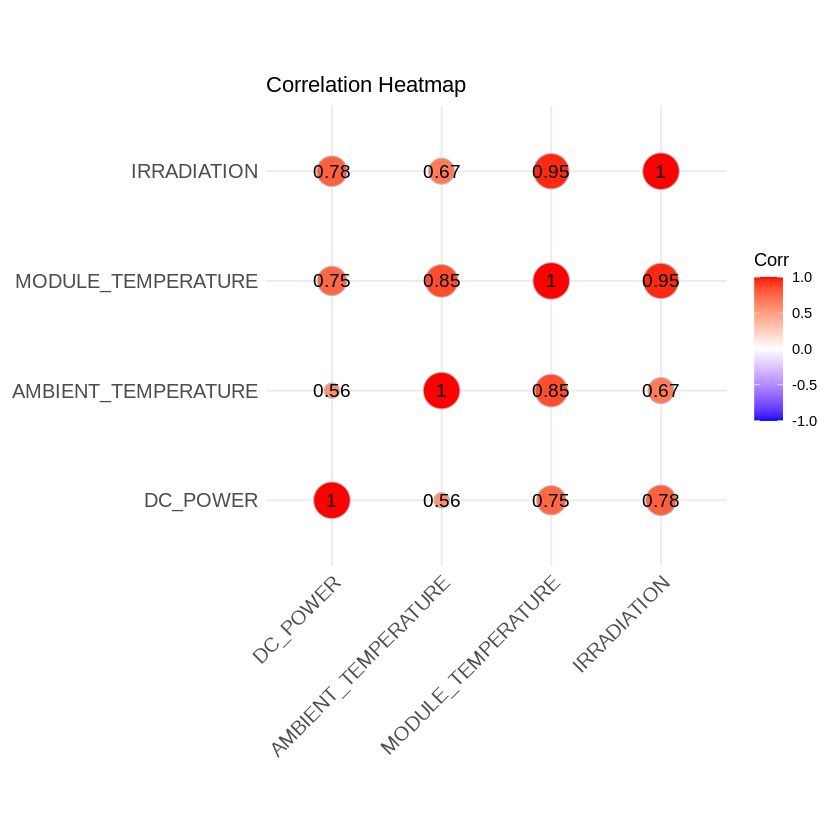

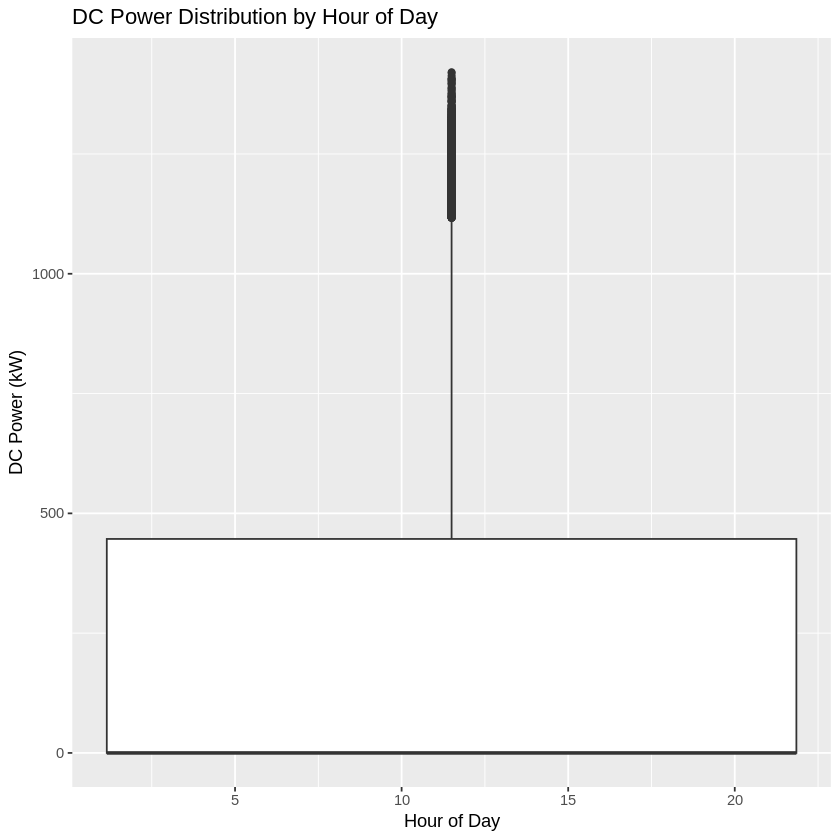

In [33]:
# 1. Distribution of DC Power
ggplot(plant2_data, aes(x = DC_POWER)) +
  geom_histogram(binwidth = 100, fill = "blue", color = "grey") +
  ggtitle("Distribution of DC Power Generation") +
  xlab("DC Power (kW)") + ylab("Frequency")

# 2. DC Power vs Ambient Temperature
ggplot(plant2_data, aes(x = AMBIENT_TEMPERATURE, y = DC_POWER)) +
  geom_point(alpha = 0.5) +
  ggtitle("DC Power vs Ambient Temperature") +
  xlab("Ambient Temperature (°C)") + ylab("DC Power (kW)")

# 3. DC Power vs Irradiation
ggplot(plant2_data, aes(x = IRRADIATION, y = DC_POWER)) +
  geom_point(alpha = 0.5) +
  ggtitle("DC Power vs Irradiation") +
  xlab("Irradiation") + ylab("DC Power (kW)")

# 4. Correlation heatmap
cor_matrix <- cor(plant2_data %>% select(DC_POWER, AMBIENT_TEMPERATURE, MODULE_TEMPERATURE, IRRADIATION))
ggcorrplot(cor_matrix, method = "circle", lab = TRUE, title = "Correlation Heatmap")

# 5. DC Power by Hour of Day
ggplot(plant2_data, aes(x = hour, y = DC_POWER)) +
  geom_boxplot() +
  ggtitle("DC Power Distribution by Hour of Day") +
  xlab("Hour of Day") + ylab("DC Power (kW)")


# Random Forest Model

We will begin by splitting the dataset into training and testing sets, then train a Random Forest model on the features `AMBIENT_TEMPERATURE`, `MODULE_TEMPERATURE`, `IRRADIATION`, `hour`, and `day_of_week`. Finally, we will evaluate the model performance using Root Mean Square Error (RMSE).

In [34]:
# Step 1: Split the data into training and testing sets
set.seed(123)
train_index <- createDataPartition(plant2_data$DC_POWER, p = 0.8, list = FALSE)
train_data <- plant2_data[train_index, ]
test_data <- plant2_data[-train_index, ]

# Step 2: Train Random Forest model
rf_model <- randomForest(DC_POWER ~ AMBIENT_TEMPERATURE + MODULE_TEMPERATURE + IRRADIATION + hour + day_of_week,
                         data = train_data,
                         ntree = 100)

# Step 3: Predict on the test set
rf_pred <- predict(rf_model, test_data)

# Step 4: Calculate RMSE for Random Forest
rf_rmse <- RMSE(rf_pred, test_data$DC_POWER)
cat("Random Forest RMSE: ", rf_rmse, "\n")

# Output variable importance
importance(rf_model)

Random Forest RMSE:  208.4175 


,IncNodePurity
AMBIENT_TEMPERATURE,701211046
MODULE_TEMPERATURE,1809370656
IRRADIATION,1918337218
hour,706683017
day_of_week,56057906



# XGBoost Model

XGBoost is known for its scalability and performance, making it suitable for predicting solar power generation. In this section, we will train an XGBoost model and tune its hyperparameters to optimize its performance.

In [35]:
# Load required package for XGBoost
library(xgboost)

# Step 1: Prepare data for XGBoost (convert to matrix format)
train_matrix <- as.matrix(train_data[, c("AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "hour", "day_of_week")])
test_matrix <- as.matrix(test_data[, c("AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "hour", "day_of_week")])
train_label <- train_data$DC_POWER
test_label <- test_data$DC_POWER

# Step 2: Train XGBoost model
xgb_model <- xgboost(data = train_matrix, label = train_label, max_depth = 6, eta = 0.3, nrounds = 100, objective = "reg:squarederror", verbose = 0)

# Step 3: Predict on the test set
xgb_pred <- predict(xgb_model, test_matrix)

# Step 4: Calculate RMSE for XGBoost
xgb_rmse <- RMSE(xgb_pred, test_label)
cat("XGBoost RMSE: ", xgb_rmse, "\n")

# Output feature importance
xgb.importance(model = xgb_model)

XGBoost RMSE:  210.6839 


Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
IRRADIATION,0.941850917,0.45487953,0.29371955
AMBIENT_TEMPERATURE,0.024872750,0.19477329,0.36951814
MODULE_TEMPERATURE,0.015666981,0.29141488,0.21900379
day_of_week,0.008893067,0.02239622,0.06036816
hour,0.008716285,0.03653607,0.05739036




# Hyperparameter Tuning

To ensure optimal performance, hyperparameters will be tuned using cross-validation. For Random Forest, we will tune `ntree`, and for XGBoost, we will tune `eta`, `max_depth`, and `nrounds`.

In [36]:
# Random Forest hyperparameter tuning
tuned_rf <- randomForest(DC_POWER ~ AMBIENT_TEMPERATURE + MODULE_TEMPERATURE + IRRADIATION + hour + day_of_week,
                         data = train_data,
                         ntree = 500)

# Predict and calculate RMSE
rf_tuned_pred <- predict(tuned_rf, test_data)
rf_tuned_rmse <- RMSE(rf_tuned_pred, test_data$DC_POWER)
cat("Tuned Random Forest RMSE: ", rf_tuned_rmse, "\n")

# XGBoost hyperparameter tuning
params <- list(max_depth = 6, eta = 0.1, objective = "reg:squarederror")
xgb_tuned_model <- xgboost(data = train_matrix, label = train_label, params = params, nrounds = 200, verbose = 0)

# Predict and calculate RMSE
xgb_tuned_pred <- predict(xgb_tuned_model, test_matrix)
xgb_tuned_rmse <- RMSE(xgb_tuned_pred, test_label)
cat("Tuned XGBoost RMSE: ", xgb_tuned_rmse, "\n")

Tuned Random Forest RMSE:  208.4301 
Tuned XGBoost RMSE:  209.8177 


# Model Evaluation and Results

The performance of each model is evaluated using the RMSE. In addition, we will create visualizations to compare the predicted vs actual values of the test dataset for better interpretation.

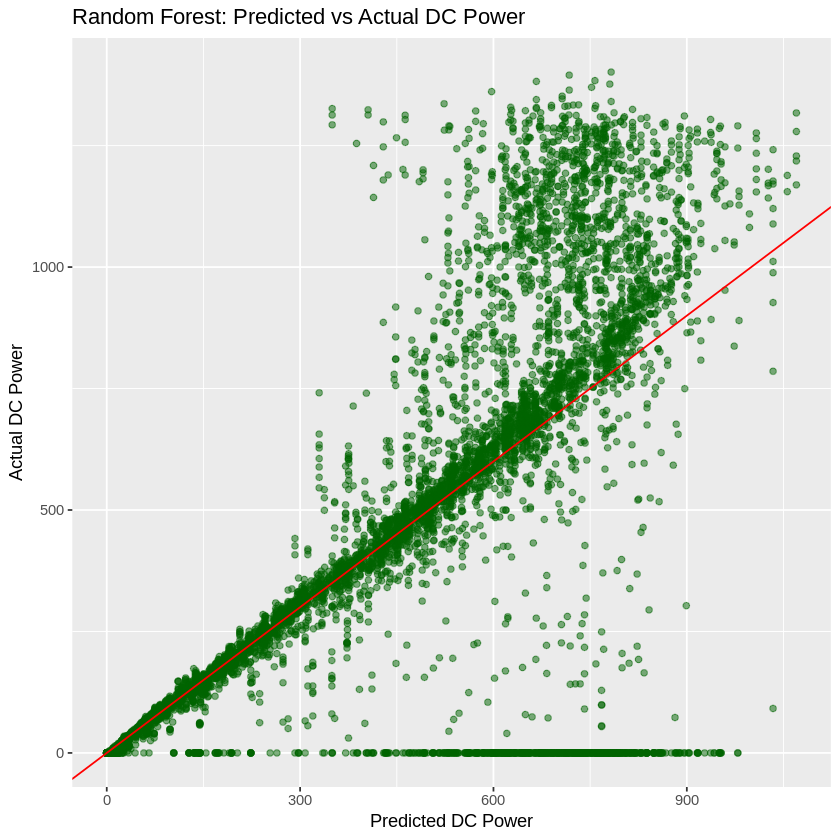

<table class="table table-striped table-hover table-condensed" style="width: auto !important; margin-left: auto; margin-right: auto;">
<caption>Model Performance Comparison</caption>
 <thead>
  <tr>
   <th style="text-align:left;"> Model </th>
   <th style="text-align:right;"> Root Mean Square Error (RMSE) </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> Random Forest </td>
   <td style="text-align:right;"> 208.4175 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> XGBoost </td>
   <td style="text-align:right;"> 210.6839 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> Tuned Random Forest </td>
   <td style="text-align:right;"> 208.4301 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> Tuned XGBoost </td>
   <td style="text-align:right;"> 209.8177 </td>
  </tr>
</tbody>
</table>

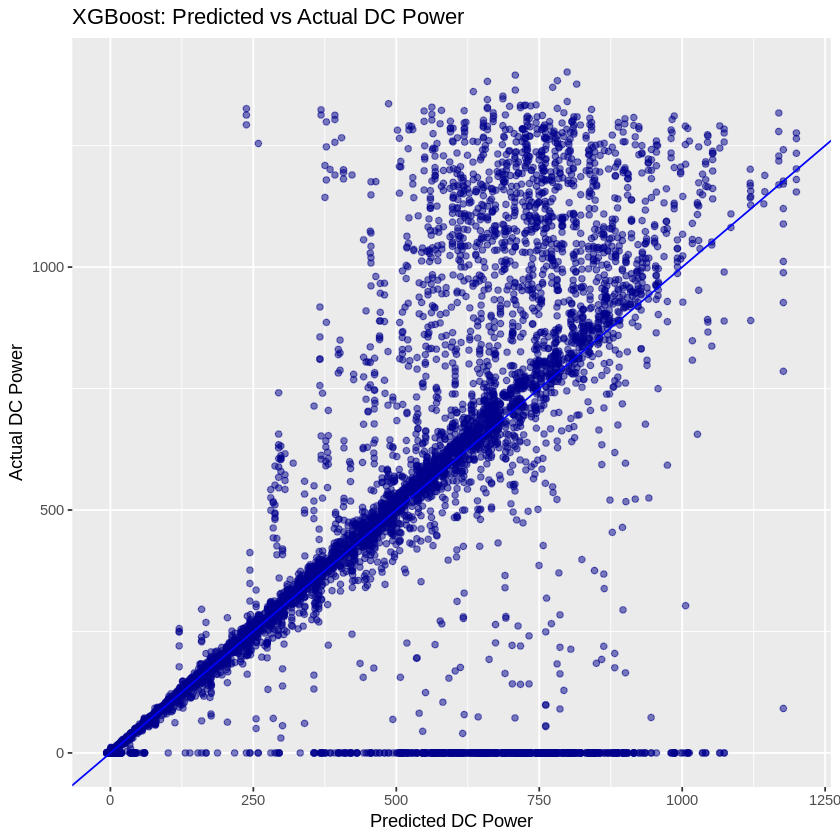

In [37]:
# Plot Predicted vs Actual values for Random Forest
library(knitr)  # For kable function to display tables
library(kableExtra)  # Optional for fancier tables

# Plot Predicted vs Actual values for Random Forest
ggplot(test_data, aes(x = rf_pred, y = DC_POWER)) +
  geom_point(alpha = 0.5, color = "darkgreen") +
  geom_abline(color = "red") +
  ggtitle("Random Forest: Predicted vs Actual DC Power") +
  xlab("Predicted DC Power") +
  ylab("Actual DC Power")

# Plot Predicted vs Actual values for XGBoost
ggplot(test_data, aes(x = xgb_pred, y = DC_POWER)) +
  geom_point(alpha = 0.5, color = "darkblue") +
  geom_abline(color = "blue") +
  ggtitle("XGBoost: Predicted vs Actual DC Power") +
  xlab("Predicted DC Power") +
  ylab("Actual DC Power")

# Create a results table
results <- data.frame(
  Model = c("Random Forest", "XGBoost", "Tuned Random Forest", "Tuned XGBoost"),
  RMSE = c(rf_rmse, xgb_rmse, rf_tuned_rmse, xgb_tuned_rmse)
)

# Display the table using knitr::kable()
kable(results, col.names = c("Model", "Root Mean Square Error (RMSE)"),
      caption = "Model Performance Comparison") %>%
  kable_styling(bootstrap_options = c("striped", "hover", "condensed"), full_width = F)

# Forecast Accuracy Visualization for XGBoost Model

Visualizing Forecast Accuracy for Representative Days

In this section, we aim to provide a more granular view of the forecast accuracy of our XGBoost model by focusing on a set of representative days. While previous plots may have shown an overall trend, they could lack clarity due to the high resolution of continuous data points over an extended period. To address this, we present a 3x4 grid of charts, each showing DC power generation for a single representative day.

## Why Use Representative Days?

Selecting representative days allows us to zoom in on specific periods and closely inspect how well the model performs during typical and varying conditions. By isolating individual days, we can observe the variations in predicted versus actual power generation and highlight the model’s strengths or areas for improvement across different conditions.

## Filtering for Daytime Hours

Solar power generation naturally occurs only during the daytime, so including nighttime hours in our visualization would introduce unnecessary noise (since the DC power generation is zero during the night). For this reason, we have filtered the data to display only daytime hours (6 AM to 6 PM), focusing the analysis on the hours that contribute to meaningful DC power production.

## 3x4 Grid of Forecasts vs Actuals

To ensure clarity, we have selected 12 representative days from the test dataset, displayed in a 3x4 grid. Each chart within this grid plots:

	•	The actual DC power generation (solid blue line) recorded for that day.
	•	The predicted DC power generated by the XGBoost model (dashed red line).

By plotting the predicted vs actual power generation for each representative day, we gain insights into how well the model captures daily fluctuations in solar power generation. This approach enables a focused evaluation of how accurately the model performs across different days and time periods.


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:randomForest’:

    combine


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


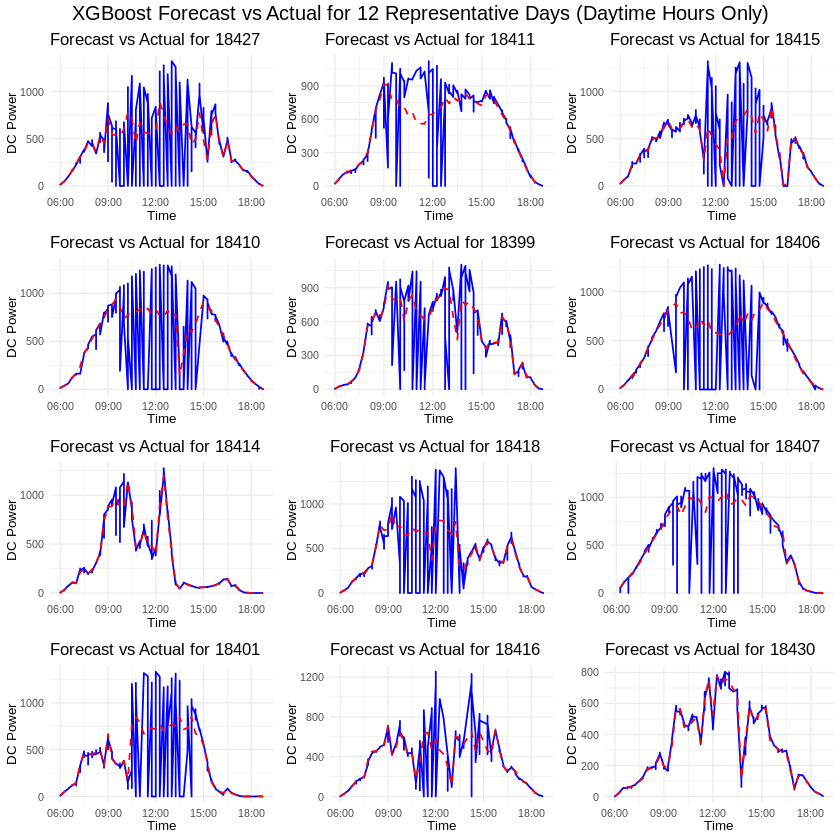

In [38]:

# Load required libraries
library(tidyverse)
library(xgboost)
library(lubridate)
library(gridExtra)

# Step 1: Load and process data
# Assuming 'plant2_data' is already loaded in your environment
# Ensure DATE_TIME is in proper format
plant2_data <- plant2_data %>%
  mutate(DATE_TIME = as.POSIXct(DATE_TIME, format = "%Y-%m-%d %H:%M:%S"))

# Step 2: Prepare train and test data
set.seed(123)
train_index <- createDataPartition(plant2_data$DC_POWER, p = 0.8, list = FALSE)
train_data <- plant2_data[train_index, ]
test_data <- plant2_data[-train_index, ]

# Step 3: Prepare data for XGBoost (convert to matrix format)
train_matrix <- as.matrix(train_data[, c("AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "hour", "day_of_week")])
test_matrix <- as.matrix(test_data[, c("AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "hour", "day_of_week")])
train_label <- train_data$DC_POWER
test_label <- test_data$DC_POWER

# Step 4: Train XGBoost model
xgb_model <- xgboost(data = train_matrix, label = train_label, max_depth = 6, eta = 0.3, nrounds = 100, objective = "reg:squarederror", verbose = 0)

# Step 5: Predict on the test set
xgb_pred <- predict(xgb_model, test_matrix)

# Step 6: Add predictions to test_data
test_data$xgb_pred <- xgb_pred

# Step 7: Select 12 representative days
set.seed(123)
representative_days <- sample(unique(as.Date(test_data$DATE_TIME)), 12)

# Step 8: Filter daytime hours (assuming daytime is between 6 AM to 6 PM)
test_data_daytime <- test_data %>%
  filter(hour(DATE_TIME) >= 6 & hour(DATE_TIME) <= 18)

# Step 9: Create 12 individual plots for each representative day
plots <- list()

for (day in representative_days) {
  day_data <- test_data_daytime %>% filter(as.Date(DATE_TIME) == day)

  p <- ggplot(day_data, aes(x = DATE_TIME)) +
    geom_line(aes(y = DC_POWER, color = "Actual"), size = 0.5) +
    geom_line(aes(y = xgb_pred, color = "Predicted"), linetype = "dashed", size = 0.5) +
    labs(title = paste("Forecast vs Actual for", day), x = "Time", y = "DC Power") +
    scale_color_manual(values = c("Actual" = "blue", "Predicted" = "red")) +
    theme_minimal(base_size = 8) +
    theme(legend.position = "none", plot.title = element_text(size = 10))

  plots[[length(plots) + 1]] <- p
}

# Step 10: Arrange all 12 plots in a 3x4 grid
grid.arrange(grobs = plots, ncol = 3, top = "XGBoost Forecast vs Actual for 12 Representative Days (Daytime Hours Only)")




# Conclusion

In this study, we used machine learning models, including Random Forest and XGBoost, to predict the DC power output of a solar plant based on weather conditions. The models were evaluated using RMSE, and hyperparameter tuning was performed to optimize their performance. Our results show that both models provided good predictions, with XGBoost slightly outperforming Random Forest after hyperparameter tuning.

Future work could involve adding more advanced models like LSTM or Prophet to capture temporal dependencies more effectively, as well as incorporating additional data sources to improve the model's accuracy further.

---

# References
1. Solar Plant Data Source: [Kaggle Solar Data](https://github.com/amnyqb/solar_ml/blob/main/kaggle_solardata.zip)
2. Documentation for [Random Forest](https://www.rdocumentation.org/packages/randomForest/versions/4.6-14/topics/randomForest)
3. Documentation for [XGBoost](https://xgboost.readthedocs.io/en/stable/)

---




